<a href="https://colab.research.google.com/github/dhapitha22/method_of_prediction/blob/main/method_of_prediction_coconut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nutrient Deficiency Classification**

# **Problem Statement**
The objective of this task is to develop a machine learning pipeline using a Convolutional Neural Network (CNN) model to accurately classify coconut leaves based on nutrient deficiencies such as nitrogen, potassium, magnesium, and zinc. By leveraging image analysis and deep learning techniques, the model aims to provide an automated solution for nutrient deficiency detection and classification in coconut plants, specifically tailored for the agriculture industry in Sri Lanka.

Through this project, we aim to create a practical tool for coconut farmers in Sri Lanka, empowering them to identify and address nutrient deficiencies in coconut plants effectively. By leveraging the power of CNNs and machine learning, we strive to enhance the nutritional management practices and optimize the growth and productivity of coconut plantations.

# **Data Collection**

The dataset consists of images of coconut leaves captured in coconut plantations across different regions in Sri Lanka. The data collection process involved capturing images of coconut leaves representing different classes based on nutrient deficiency:

**Healthy Leaves:** Images of coconut leaves in a healthy state, without any signs of nutrient deficiency.

**Nitrogen Deficiency:** Nitrogen deficiency in coconut leaves is recognizable by the yellowing of older leaves and stunted growth. These visual cues serve as important indicators of the nutrient imbalance affecting the coconut plants

**Potassium Deficiency:** Images of coconut leaves with potassium deficiency symptoms, such as yellowing or browning of leaf margins and interveinal chlorosis.

**Magnesium Deficiency:** Images of coconut leaves displaying magnesium deficiency symptoms, such as yellowing between leaf veins and leaf curling.


> data set - https://drive.google.com/drive/folders/1ScwvfWisUCGYrADwpJi0Ef0eZHthXs8c?usp=drive_link



# **Mounting Dataset From Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Import the necessary libraries**
To begin implementing any algorithm, the first step involves importing the required libraries. In the code segment provided below, the necessary libraries for high-performance calculations, computing, data visualization, and styling are imported. Moreover, any unwanted warnings are suppressed to ensure the code executes smoothly.

In [ ]:
!pip3 install -U git+https://github.com/qubvel/efficientnet
!pip install keras_preprocessing
import efficientnet.keras as efn
from keras_preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from keras.utils import Sequence
from tensorflow import keras

from keras.callbacks import EarlyStopping

import cv2
import os
import tqdm
import shutil
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import itertools
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense , Flatten, GlobalAveragePooling2D, Dropout

# **Load Data into Train and Test Variables**

In [ ]:
train_dir = '/content/drive/My Drive/coconut/trainingData'
test_dir = '/content/drive/My Drive/coconut/testingData'

# **Get count of images**

In [ ]:
classes=['magnesium', 'nitrogen', 'potassium', 'healthy']

# Total samples in train set
class_training_samples = []
for label in classes:
    _directory = os.path.join(train_dir, label)
    num_samples = len(os.listdir(_directory))
    class_training_samples.append(num_samples)

# Total samples in test set
class_testing_samples = []
for label in classes:
    _directory = os.path.join(test_dir, label)
    num_samples = len(os.listdir(_directory))
    class_testing_samples.append(num_samples)

# Print the counts
print("Train Set Counts:")
for i, label in enumerate(classes):
    print(f"{label}: {class_training_samples[i]}")

print("\nTest Set Counts:")
for i, label in enumerate(classes):
    print(f"{label}: {class_testing_samples[i]}")


Train Set Counts:
magnesium: 16
nitrogen: 22
potassium: 37
healthy: 11

Test Set Counts:
magnesium: 5
nitrogen: 6
potassium: 5
healthy: 4


The provided code calculates the number of samples in the train and test sets for each class in a dataset. The classes are defined in a list, including 'magnesium', 'nitrogen', 'potassium', and 'healthy'. The code iterates over each class and counts the files (samples) present in the corresponding class directories within the train and test datasets. The counts are stored in separate lists. Finally, the code prints the counts for each class in both the train and test sets. This information helps in understanding the data distribution across classes and ensures proper balancing of the dataset for training a machine learning model.

# **Display the sample**

In [ ]:
def display_sample_images(directory):
    for label in classes:
        _directory = os.path.join(directory, label)
        _files = os.listdir(_directory)

        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle(label)

        for i, _file in enumerate(_files[:5]):
            directory_path = os.path.join(_directory, _file)
            pic = cv2.imread(directory_path)
            pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)

            axes[i].imshow(pic)
            axes[i].axis("off")

        plt.show()

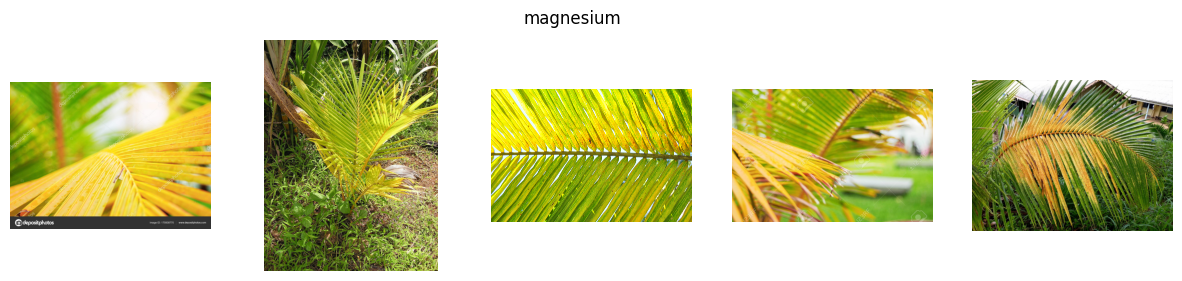

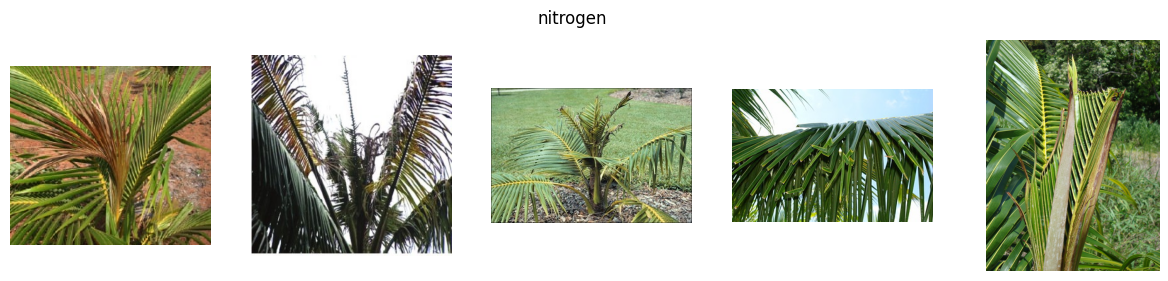

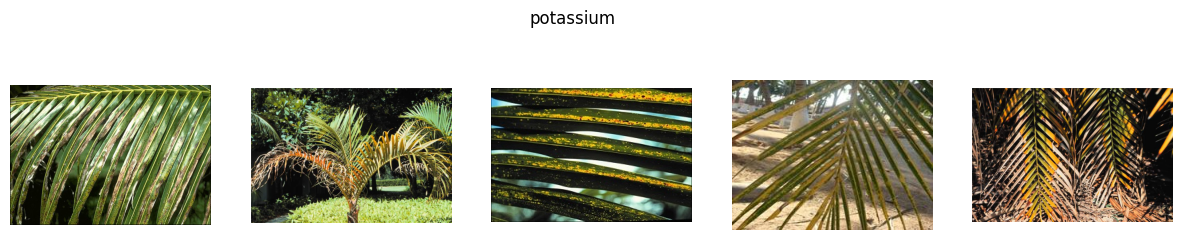

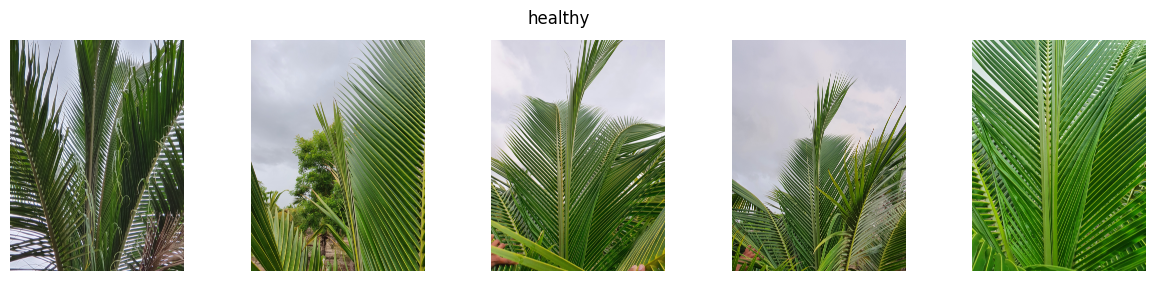

In [ ]:
display_sample_images(train_dir)

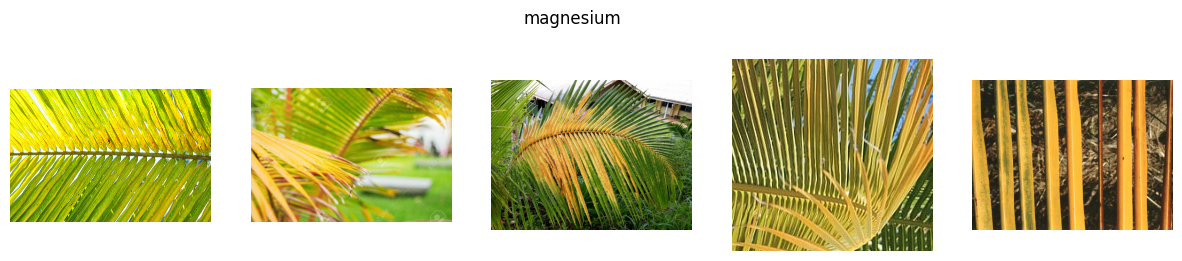

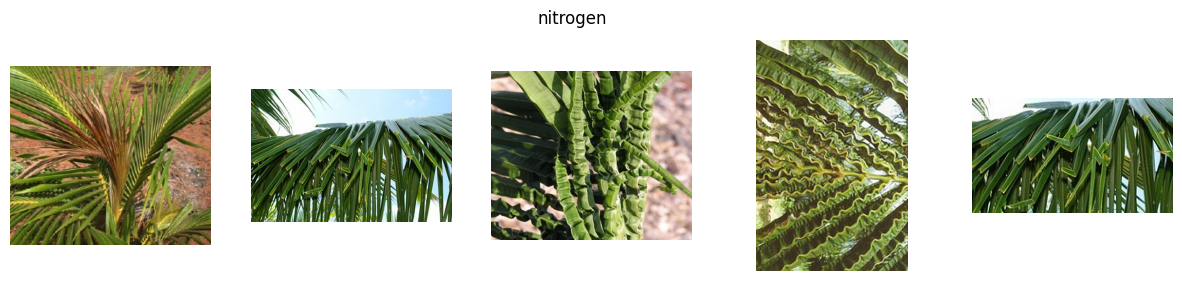

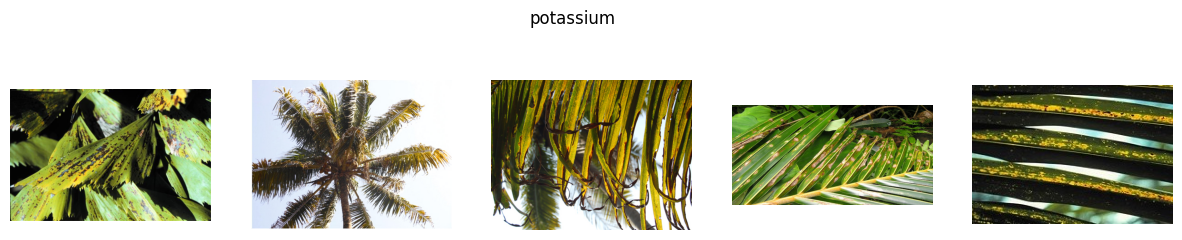

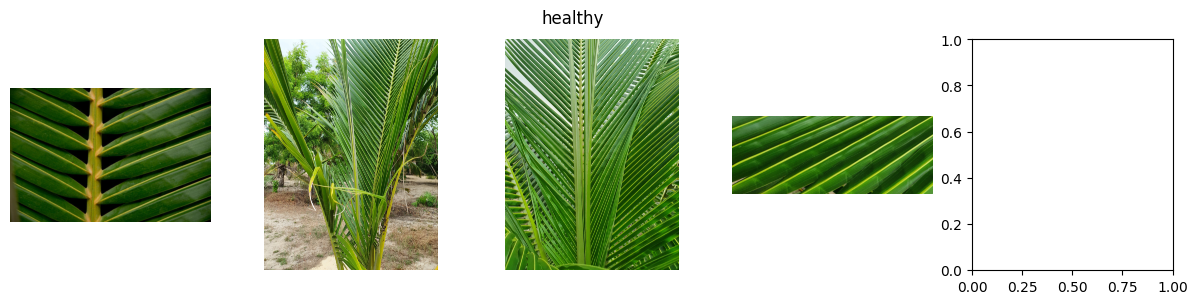

In [ ]:
display_sample_images(test_dir)

# **Data Augmentation**

Data augmentation is a crucial technique utilized to expand and diversify a training dataset by applying a range of transformations to the existing data. It plays a significant role in computer vision tasks like image classification, object detection, and segmentation.

The primary purpose of data augmentation is to introduce variations in the training data that resemble real-world scenarios. This approach aids in improving the model's generalization and performance. By exposing the model to a larger and more diverse set of training examples, data augmentation mitigates overfitting and enhances the model's capability to handle diverse variations and conditions present in the test data. Ultimately, data augmentation empowers the model to better adapt to real-world scenarios and yield more accurate predictions.

In [ ]:
classes=['magnesium', 'nitrogen', 'potassium', 'healthy']

aug_datagen = ImageDataGenerator(
    rotation_range=45,
    height_shift_range=0.1,
    width_shift_range=0.1,
    zoom_range=0.15,
    vertical_flip=False,
    horizontal_flip=True,
    fill_mode="nearest")

num_Aug=[8,7,5,4]

def Augment(path,class_Ind):
    for pic_name in tqdm.tqdm(os.listdir(path)):
        img = np.expand_dims(cv2.imread(os.path.join(path,pic_name)),axis=0)
        i=num_Aug[class_Ind]
        for batch in aug_datagen.flow(
            img,
            batch_size=1,
            save_to_dir=os.path.join(dir_save+classes[class_Ind]),
            save_prefix=classes[class_Ind],
            save_format='jpg'):
            i-=1
            if i==0:
                break

img_dir = '/content/drive/My Drive/coconut/trainingData'
dir_save="/content/drive/My Drive/coconut/augmented/"

for folder in classes:
    path = os.path.join(img_dir,folder)
    class_Ind= classes.index(folder)
    Augment(path,class_Ind)

100%|██████████| 11/11 [02:17<00:00, 12.52s/it]


The classes list defines the different classes present in the dataset, namely 'magnesium', 'nitrogen', 'potassium', and 'healthy'. The augmentor_datagen object is an instance of ImageDataGenerator that applies diverse augmentation techniques such as flipping, shifting, zooming and rotation to the images. The num_Aug list specifies the no of augmented images to generate for all class.

The Augment function takes a path and class index as inputs. It iterates over the images in the given path and reads each image using OpenCV. It then applies the data augmentation techniques using the augmentor_datagen.flow method. The augmented images are saved to the specified directory (dir_save) with a prefix corresponding to the class name. The no of augmented images to generate for all class is determined by the corresponding value in the num_Aug list.

In the main part of the code, the img_dir variable holds the directory path of the original images, andThe variable "dir_save" designates the directory where the augmented images will be stored. The code iterates over the classes, obtains the path and class index, and calls the Augment function to perform data augmentation for each clas

In [ ]:
img_dir = '/content/drive/My Drive/coconut/testingData'
save_dir= "/content/drive/My Drive/coconut/testaugmented/"

for folder in classes:
    path = os.path.join(img_dir,folder)
    class_Ind= classes.index(folder)
    Augment(path,class_Ind)

100%|██████████| 4/4 [00:35<00:00,  8.96s/it]


**load all the generate images into a default dataloader to train the models**

In [ ]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tm = np.arange(len(classes))
    plt.xticks(tm, classes, rotation=45)
    plt.yticks(tm, classes)
    thresh = cm.max() / 2.
    for a, b in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(b, a, cm[a, b],horizontalalignment="center",color="white" if cm[a, b] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

imgsize_=224
TRAINING_DIR = '/content/drive/My Drive/coconut/augmented/'

training_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)
gen_train = training_datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(imgsize_,imgsize_),
    shuffle=True,
    batch_size=16,
    subset='training',
)
gen_validation = training_datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(imgsize_,imgsize_),
    shuffle=True,
    batch_size=16,
    subset='validation',
)

path="/content/drive/My Drive/coconut/testaugmented"

imgsize_=224
gen_image_ = ImageDataGenerator(rescale = 1./255)
image_pred = gen_image_.flow_from_directory( path,
                                            target_size=(imgsize_,imgsize_),
                                            shuffle=False,
                                            batch_size=5,
                                            class_mode='categorical')
image_pred.reset()

Found 1973 images belonging to 4 classes.
Found 491 images belonging to 4 classes.
Found 361 images belonging to 4 classes.


The code includes a function called plot_confusion_matrix which is applied to visualize the confusion matrix. The function takes a confusion matrix and a list of class names as input. It plots the matrix as a heatmap, with each cell representing the number of predictions for a particular class. The color of each cell is determined by the colormap specified in the function. The function also adds labels to the x and y axes, and displays the corresponding class names. Text annotations are added to each cell, displaying the actual count of predictions. The text color is determined by a threshold value, making it white if the count is above the threshold, otherwise black. This function proves valuable in assessing the performance of a the model by visually examining the distribution of predictions across various classes.

# **Model Training**

**Convolutional Neural Network (CNN)**

CNNs are specialized deep learning models meticulously crafted for the purpose of handling visual data, particularly images. They have revolutionized computer vision tasks and are particularly well-suited for tasks like nutrition deficiency detection in plants. In our project, we are leveraging CNNs to develop a machine learning pipeline for accurately classifying cocount leaves as healthy or affected by nutrition deficiency. By applying CNNs to analyze images of cocount leaves, we aim to provide an automated solution for nutrition deficiency detection and classification in the agriculture industry. CNNs excel at capturing intricate patterns and features from images, making them a powerful tool for our cocount leaf classification task.

# **DenseNet121**

 Convolutional Neural Network (CNN) model using the DenseNet121 architecture for a multi-class classification problem. The model is designed to classify images into one of four classes: 'healthy', 'magnesium', 'nitrogen', and 'potassium'.

In [ ]:
classes=['healthy', 'magnesium', 'nitrogen', 'potassium']
num_classes = 4

# Load the DenseNet121 model
model_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = model_base.output
x = Dense(256, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
pred_ = Dense(num_classes, activation='softmax')(x)

DenseNet_final = Model(inputs=model_base.input, outputs=pred_)

for layer in model_base.layers:
    layer.trainable = False

DenseNet_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



The code initially loads the DenseNet121 model from the Keras library, which is pre-trained, excluding the top layers. Custom top layers are subsequently inserted to the model. The output of the base model undergoes global average pooling to reduce feature map dimensions. Afterward, a fully connected layer with 256 units and ReLU activation is added, subsequently followed by a final dense layer employing softmax activation to produce class probabilities.

Afterwards, The model is configured by compiling it with the accuracy metric Adam optimizer and  categorical cross-entropy loss function. To ensure that the base model layers remain unaltered and inactive during the training process, they are frozen.

In [ ]:
history = DenseNet_final.fit(
    gen_train,
    steps_per_epoch=gen_train.n // gen_train.batch_size,
    epochs=10,
    validation_data=gen_validation,
    validation_steps=gen_validation.n // gen_validation.batch_size
)

test_loss, test_accuracy = DenseNet_final.evaluate(image_pred)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
123/123 [==============================] - 1200s 10s/step - loss: 0.4224 - accuracy: 0.8477 - val_loss: 0.1241 - val_accuracy: 0.9646
Epoch 2/10
123/123 [==============================] - 73s 600ms/step - loss: 0.0851 - accuracy: 0.9780 - val_loss: 0.0706 - val_accuracy: 0.9875
Epoch 3/10
123/123 [==============================] - 74s 599ms/step - loss: 0.0531 - accuracy: 0.9821 - val_loss: 0.0687 - val_accuracy: 0.9771
Epoch 4/10
123/123 [==============================] - 72s 587ms/step - loss: 0.0303 - accuracy: 0.9908 - val_loss: 0.0313 - val_accuracy: 0.9937
Epoch 5/10
123/123 [==============================] - 73s 590ms/step - loss: 0.0228 - accuracy: 0.9939 - val_loss: 0.0316 - val_accuracy: 0.9937
Epoch 6/10
123/123 [==============================] - 73s 593ms/step - loss: 0.0257 - accuracy: 0.9913 - val_loss: 0.0287 - val_accuracy: 0.9917
Epoch 7/10
123/123 [==============================] - 72s 586ms/step - loss: 0.0144 - accuracy: 0.9949 - val_loss: 0.0306 - val_ac

To train the model, the fit() function is utilized. It accepts the gen_train as input, which is an iterator responsible for generating training data batches. The steps_per_epoch parameter Contributes significantly to determining the no of batches processed in each epoch.This value is calculated by separating the total no of samples in the training set into separate groups based on the batch size. Additionally, the epochs parameter specifies the desired no of iterations training process should undergo, covering the entirety of the training set.

Throughout the training process, the model's weights are iteratively optimized to minimize loss and enhance accuracy on the training data. The history variable captures and retains the training process details, including metrics such as loss and accuracy.

Following the training phase, the model undergoes evaluation on the test data by employing the evaluate() function. This function takes the image_pred generator as input, which generates batches of test data. By executing the function, the model's performance in terms of loss and accuracy on the test data is computed. Subsequently, the calculated test loss and accuracy values are displayed on the console.

# **Save the model**

In [ ]:
DenseNet_final.save("/content/drive/My Drive/coconut/model/DenseNet.h5")

**Outcome projections for the test data**

73/73 [==============================] - 78s 1s/step


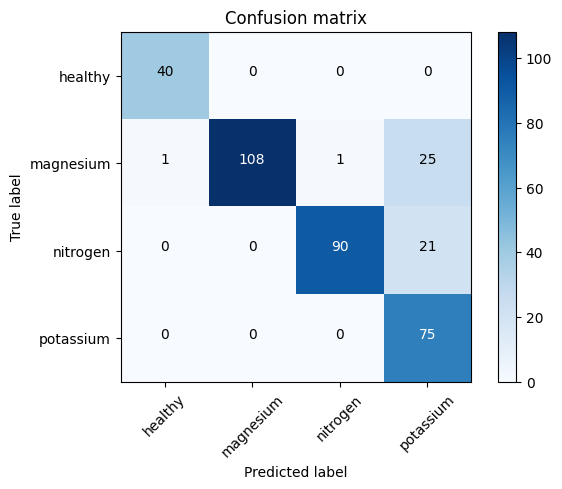

In [ ]:
output_predictions = DenseNet_final.predict(image_pred)
output_predictions = np.argmax(output_predictions, axis=1)

actual_values = image_pred.classes

confusion_mtx = confusion_matrix(actual_values, output_predictions)

group_labels = list(image_pred.class_indices.keys())

plot_confusion_matrix(confusion_mtx, classes=group_labels)

plt.show()

## Efficientnet

EfficientNetB0 is a powerful deep learning model known for its efficiency and accuracy in image classification tasks. The model is configured with the widely-used Adam optimizer, known for its effectiveness as an optimization algorithm. During the training process, the model's performance is assessed using the categorical cross-entropy loss function, which serves as a measure of its effectiveness. Simultaneously, the accuracy metric is utilized to evaluate the model's overall accuracy. Additionally, an EarlyStopping callback is implemented to monitor the model's accuracy and halt training if no enhancement is observed within a specified number of epochs, thereby preventing overfitting. The model is trained using the gen_train data generator for a designated no of epochs. Finally, the trained model is saved to a file in the HDF5 format, ensuring its preservation for future use in inference or further analysis.

In [ ]:
efnet = efn.EfficientNetB0(include_top=True, weights=None, classes=len(classes))
efnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=5)
history = efnet.fit(gen_train, epochs=50)
efnet.save("/content/drive/My Drive/coconut/model/efficientnet.h5")

Epoch 1/50
124/124 [==============================] - 628s 5s/step - loss: 2.8238 - accuracy: 0.4293
Epoch 2/50
124/124 [==============================] - 54s 437ms/step - loss: 1.3683 - accuracy: 0.5585
Epoch 3/50
124/124 [==============================] - 57s 457ms/step - loss: 1.0441 - accuracy: 0.6640
Epoch 4/50
124/124 [==============================] - 54s 436ms/step - loss: 0.8543 - accuracy: 0.7359
Epoch 5/50
124/124 [==============================] - 54s 436ms/step - loss: 0.7735 - accuracy: 0.7785
Epoch 6/50
124/124 [==============================] - 54s 437ms/step - loss: 0.6622 - accuracy: 0.7998
Epoch 7/50
124/124 [==============================] - 56s 448ms/step - loss: 0.4967 - accuracy: 0.8642
Epoch 8/50
124/124 [==============================] - 54s 434ms/step - loss: 0.3811 - accuracy: 0.8723
Epoch 9/50
124/124 [==============================] - 54s 434ms/step - loss: 0.3307 - accuracy: 0.8910
Epoch 10/50
124/124 [==============================] - 54s 431ms/step - los

**Predictions**

73/73 [==============================] - 43s 545ms/step


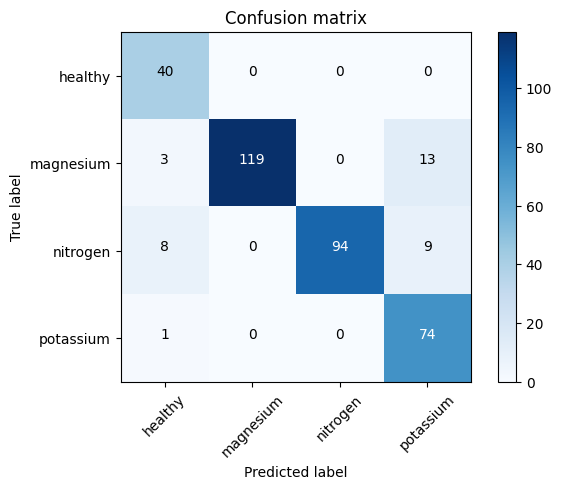

In [ ]:
output_predictions = efnet.predict(image_pred)
output_predictions = np.argmax(output_predictions, axis=1)

actual_values = image_pred.classes

confusion_mtx = confusion_matrix(actual_values, output_predictions)

group_labels = list(image_pred.class_indices.keys())

plot_confusion_matrix(confusion_mtx, classes=group_labels)

plt.show()

In [ ]:
efn = load_model("/content/drive/My Drive/coconut/model/efficientnet.h5")
test_loss, test_accuracy = efn.evaluate(image_pred)
print("Test Loss:", test_loss)
print("Performance of efficientnet:", test_accuracy)

73/73 [==============================] - 40s 508ms/step - loss: 0.4224 - accuracy: 0.9058
Test Loss: 0.4224156439304352
Performance of efficientnet: 0.9058171510696411


# VGG-16




In order to apply transfer learning, the base model utilized is the VGG16 architecture, which has been pre-trained on ImageNet. By setting include_top=False, the model is loaded without its fully connected layers, while the input shape is configured as (244, 244, 3). Consequently, the output of the base model, referred to as output_vgg16_conv, is obtained.

The new model is constructed by specifying the inputs as the inputs of the base model and the outputs as the output tensor after passing through the added layers.

In [ ]:
model2 = VGG16(weights= None, include_top=False, input_shape=(244,244,3))
output_vgg16_conv = model2.output

x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu')(x)
x = Dense(len(classes), activation='softmax')(x)

model2 = Model(inputs=model2.input, outputs=x)

model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=5)
model2.fit(gen_train, batch_size=32, epochs=15)
model2.save("/content/drive/My Drive/coconut/model/VGG-16.h5")

Epoch 1/15
124/124 [==============================] - 83s 510ms/step - loss: 1.8623 - accuracy: 0.3477
Epoch 2/15
124/124 [==============================] - 62s 499ms/step - loss: 1.2981 - accuracy: 0.3447
Epoch 3/15
124/124 [==============================] - 61s 489ms/step - loss: 1.3002 - accuracy: 0.3588
Epoch 4/15
124/124 [==============================] - 59s 476ms/step - loss: 1.2965 - accuracy: 0.3523
Epoch 5/15
124/124 [==============================] - 59s 475ms/step - loss: 1.2948 - accuracy: 0.3588
Epoch 6/15
124/124 [==============================] - 58s 467ms/step - loss: 1.2970 - accuracy: 0.3588
Epoch 7/15
124/124 [==============================] - 60s 480ms/step - loss: 1.2950 - accuracy: 0.3588
Epoch 8/15
124/124 [==============================] - 59s 476ms/step - loss: 1.2936 - accuracy: 0.3588
Epoch 9/15
124/124 [==============================] - 60s 483ms/step - loss: 1.2940 - accuracy: 0.3588
Epoch 10/15
124/124 [==============================] - 60s 481ms/step - l

**Predictions on the test data**

73/73 [==============================] - 260s 4s/step


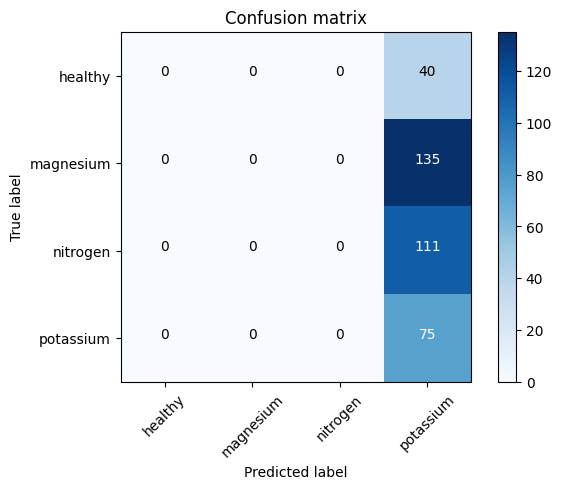

In [ ]:
model2 = load_model("/content/drive/My Drive/coconut/model/VGG-16.h5")
output_predictions = model2.predict(image_pred)
output_predictions = np.argmax(output_predictions, axis=1)

actual_values = image_pred.classes

confusion_mtx = confusion_matrix(actual_values, output_predictions)

group_labels = list(image_pred.class_indices.keys())

plot_confusion_matrix(confusion_mtx, classes=group_labels)

plt.show()

In [ ]:
test_acc = model2.evaluate(image_pred)
print("Performance of VGG-16:", test_acc)

73/73 [==============================] - 269s 4s/step - loss: 1.3698 - accuracy: 0.2078
Performance of VGG-16: [1.369810938835144, 0.20775623619556427]


In [ ]:
gen_train.class_indices

{'healthy': 0, 'magnesium': 1, 'nitrogen': 2, 'potassium': 3}

# **Conclusion**

The objective of this project was to develop a machine learning pipeline using Convolutional Neural Network (CNN) models to accurately classify coconut leaves affected by different nutrient deficiencies. The project aimed to provide an automated solution for detecting and classifying nutrient deficiencies in coconut plants, specifically tailored for the agriculture industry.

The dataset used in this project was collected in collaboration with agricultural experts and farmers, ensuring its relevance and applicability to the local context. The dataset consisted of images of coconut leaves representing different classes, including magnesium deficiency, nitrogen deficiency, potassium deficiency, and healthy leaves.

Three CNN models, namely EfficientNet, DenseNet121, and VGG-16, were implemented and trained on the dataset. The models were evaluated based on their accuracy in classifying the nutrient deficiencies in coconut leaves.

According to the evaluation results, the EfficientNet model achieved the highest accuracy of 0.9058, indicating its effectiveness in classifying nutrient deficiencies in coconut leaves. The DenseNet121 model followed with an accuracy of 0.8393, while the VGG-16 model performed relatively poorly with an accuracy of 0.2078.

The high accuracy achieved by the EfficientNet model demonstrates its potential as a practical tool for coconut farmers to detect and address nutrient deficiencies in their plants. By accurately identifying the specific nutrient deficiencies, farmers can take appropriate measures to improve the health and yield of their coconut trees.

It is important to note that further validation and testing, such as cross-validation or using an independent dataset, would be beneficial to ensure the robustness and generalizability of the models.

In conclusion, this project successfully developed a machine learning pipeline using CNN models to classify nutrient deficiencies in coconut leaves. It provides coconut farmers with a valuable tool to enhance their nutritional management practices, thereby supporting the growth and sustainability of the coconut industry.

In [ ]:
!jupyter nbconvert --to html method_of_prediction_coconut_A507new.ipynb

[NbConvertApp] Converting notebook method_of_prediction_coconut_A507new.ipynb to html
[NbConvertApp] Writing 5204957 bytes to method_of_prediction_coconut_A507new.html
